<a href="https://colab.research.google.com/github/Zahidlab/OCT-Image-Denoising/blob/main/OCT_Image_Denoiser_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import os
from os.path import join
import cv2
import sys
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

In [66]:
# Find Out if the code is running in Google Colab

COLAB = 'google.colab' in sys.modules

#setting up Device for device agnostic code

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [67]:
#Mounting Google Drive and setting the Root Data Directory for Colab Environment

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  
  # Defining Data Path
  Root_Dir = '/content/drive/MyDrive/Research/OCT datasets'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Setting Specific data path for each different data folder
first_first = os.path.join(Root_Dir,'Fast Acuisition', 'For synthetic experiments')
first_second = os.path.join(Root_Dir,'Fast Acuisition', 'Images for Dictionaries and Mapping leraning')
second = os.path.join(Root_Dir, 'Sparsity Based Denoising... _SDOCT_DATASET_2012_AMD')


In [109]:

CLEAN_IMAGES = []
NOISY_IMAGES = []
IMAGE_PATHS = []
for folder in os.listdir(first_first):
  folder_path = os.path.join(first_first, folder)

  
  # clean_img = cv2.imread(join(folder_path, 'average.tif'), 0)
  # noisy_image = cv2.imread(join(folder_path, '1.tif'), 0)

  clean_img_path = join(folder_path, 'average.tif')
  noisy_image_path = join(folder_path, '1.tif')

  IMAGE_PATHS.append([noisy_image_path, clean_img_path])





In [110]:
# second dataset
# IMAGE_PATHS = []
for folder in sorted(os.listdir(second)):

  folder_path = os.path.join(second, folder)

  if os.path.isfile(folder_path):
    continue
  
  # clean_img = cv2.imread(join(folder_path, 'average.tif'), 0)
  # noisy_image = cv2.imread(join(folder_path, '1.tif'), 0)
  for img in os.listdir(folder_path):
    if 'Averaged' in img:
      print(f"clean {img}")
      clean_img_path = join(folder_path, img)
    elif 'Raw' in img:
      print(f"noisy {img}")
      noisy_image_path = join(folder_path, img)

  IMAGE_PATHS.append([noisy_image_path, clean_img_path])

clean 1_Averaged Image.tif
noisy 1_Raw Image.tif
clean 10_Averaged Image.tif
noisy 10_Raw Image.tif
noisy 11_Raw Image.tif
clean 11_Averaged Image.tif
noisy 12_Raw Image.tif
clean 12_Averaged Image.tif
noisy 13_Raw Image.tif
clean 13_Averaged Image.tif
clean 14_Averaged Image.tif
noisy 14_Raw Image.tif
noisy 15_Raw Image.tif
clean 15_Averaged Image.tif
noisy 16_Raw Image.tif
clean 16_Averaged Image.tif
noisy 17_Raw Image.tif
clean 17_Averaged Image.tif
noisy 2_R_Raw Image.tif
clean 2_R_Averaged Image.tif
noisy 3_Raw Image.tif
clean 3_Averaged Image.tif
noisy 4_Raw Image.tif
clean 4_Averaged Image.tif
clean 5_Averaged Image.tif
noisy 5_Raw Image.tif
clean 6_Averaged Image.tif
noisy 6_Raw Image.tif
clean 7_Averaged Image.tif
noisy 7_Raw Image.tif
noisy 8_Raw Image.tif
clean 8_Averaged Image.tif
noisy 9_Raw Image.tif
clean 9_Averaged Image.tif


In [112]:
len(IMAGE_PATHS)

35

In [113]:
class CustomDataset(Dataset):

  def __init__(self, paths, transform = None):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index:int, ):

    noisy_img = Image.open(self.paths[index][0])
    clean_img = Image.open(self.paths[index][1])
    clean_img = transforms.functional.adjust_sharpness(clean_img,sharpness_factor=20)

    if self.transform:
      return self.transform(noisy_img), self.transform(clean_img)

    return noisy_img, clean_img



  def __len__(self):
    return len(self.paths)



In [114]:
# defining Transforms Needed to be done on the Images
trans = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((128,128)),

    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
])

In [115]:
# Dataset 
dataset = CustomDataset(IMAGE_PATHS, transform = trans)
len(dataset)

35

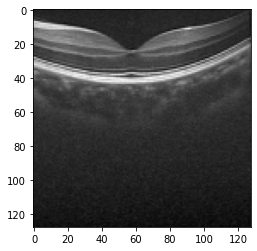

In [116]:
plt.imshow(dataset[1][1].squeeze(), cmap = 'gray')

## BATCH SIZE

In [117]:
BATCH_SIZE = 8

## Data Loader

In [118]:
train_dl = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)


In [119]:
n,c = next(iter(train_dl))
n.shape, c.shape

(torch.Size([8, 1, 128, 128]), torch.Size([8, 1, 128, 128]))

# Model Creation and Training Testing

## Generator Model

In [135]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        
        nn.Conv2d(1, 16, 3, 2,1),    #N, 16, 14, 14 
        nn.ReLU(),

        nn.Conv2d(16, 32, 3, 2,1),      #N, 32, 7, 7 
        nn.ReLU(),

        nn.Conv2d(32, 64, 7),  #N, 64, 1, 1

 
    )


    self.decoder = nn.Sequential(
        
        nn.ConvTranspose2d(64, 32, 7),    #N, 32, 7, 7
        nn.ReLU(),

        nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),   #N, 16, 14, 14
        nn.ReLU(),

        nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1),   #N, 1, 28, 28


        nn.Sigmoid()
    )



  def forward(self, x):
    encoded = self.encoder(x)
    # print(f"Shape of encoded: {encoded.shape}")
    decoded = self.decoder(encoded)
    return decoded

### Test Generator

torch.Size([1, 1, 128, 128])


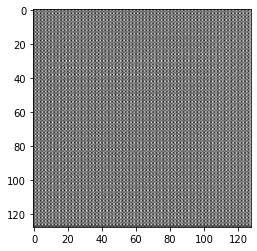

In [136]:
generator = Generator()

x = n[0].unsqueeze(dim=1)

result = generator(x)
print(result.shape)
with torch.inference_mode():
  plt.imshow(result.squeeze(), cmap='gray')

In [137]:
test_noisy_image = n[0]
gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
real_clean_image = c[0]

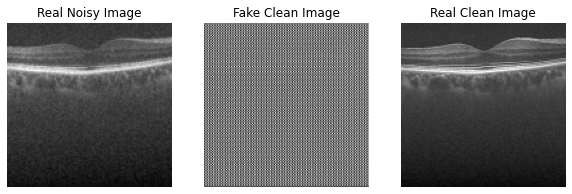

In [138]:
fig = plt.figure(figsize = (10,10))
with torch.inference_mode():
  fig.add_subplot(1,3,1)
  plt.imshow(test_noisy_image.squeeze(), cmap='gray')
  plt.title("Real Noisy Image")
  plt.axis('off')

  fig.add_subplot(1,3,2)
  plt.imshow(gen_clean_image, cmap='gray')
  plt.title("Fake Clean Image")
  plt.axis('off')

  fig.add_subplot(1,3,3)
  plt.imshow(real_clean_image.squeeze(), cmap='gray')
  plt.title("Real Clean Image")
  plt.axis('off')

## Discriminitor 

In [139]:
class Discriminator(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

        # 
        nn.Conv2d(
            in_channels = 64, 
            out_channels = 128,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

        nn.Conv2d(
            in_channels = 128, 
            out_channels = 256,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

        nn.Conv2d(
            in_channels = 256, 
            out_channels = 512,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),


    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 512*6*6, out_features = 4096),
        nn.ReLU(),
        nn.Linear(in_features = 4096, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)
    # x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)

    return x





### Test Discriminator

In [140]:
# Test Discriminator
discriminator = Discriminator(1,1)
x = torch.rand(size = [20,1,128,128])

r = discriminator(x)
print(r.shape)


torch.Size([20, 1])


## Hyperparameters

In [141]:


mseloss = nn.MSELoss()
bceloss = nn.BCEWithLogitsLoss()


optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.001, weight_decay=1e-5)
optim_g = torch.optim.Adam(generator.parameters(), lr = 0.001, weight_decay=1e-5)

## Train Step

In [142]:
import torch.nn.functional as F
def train_discriminator(noisy_images, clean_images, optimizer_d):
  optimizer_d.zero_grad()

  preds_for_real = discriminator(clean_images)
  targets_for_real = torch.ones(clean_images.size(0), 1, device = DEVICE)
  
  loss_for_real = bceloss(preds_for_real, targets_for_real)
  real_score = torch.mean(preds_for_real).item()



  fake_clean_images = generator(noisy_images)


  preds_for_fake = discriminator(fake_clean_images)
  targets_for_fake = torch.zeros(fake_clean_images.size(0), 1, device = DEVICE)

  loss_for_fake = bceloss(preds_for_fake, targets_for_fake)

  fake_score = torch.mean(preds_for_fake).item()

  diff_in_images = mseloss(clean_images, fake_clean_images)
  print(f"Disc Diff in Images: {diff_in_images}")

  loss = loss_for_real+loss_for_fake + diff_in_images

  loss.backward()

  optimizer_d.step()

  return loss.item(), real_score, fake_score




In [143]:
def train_generator(noisy_images, real_images, optimizer_g):

  optimizer_g.zero_grad()


  fake_images = generator(noisy_images)

  preds_for_fake = discriminator(fake_images)

  false_targets_for_fake = torch.ones(fake_images.size(0), 1, device = DEVICE)
  diff_in_images = mseloss(real_images, fake_images)
  print(f"Diff in Images: {diff_in_images}")
  generator_loss = bceloss(preds_for_fake, false_targets_for_fake)

  total_loss = generator_loss + diff_in_images
  total_loss.backward()
  optimizer_g.step()

  return generator_loss.item()

## Train-Test

In [144]:
def show_sample():
  test_noisy_image = n[0]
  gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
  real_clean_image = c[0]

  fig = plt.figure(figsize = (10,10))

  with torch.inference_mode():
    fig.add_subplot(1,3,1)
    plt.imshow(test_noisy_image.squeeze(), cmap='gray')
    plt.title("Real Noisy Image")
    plt.axis('off')

    fig.add_subplot(1,3,2)
    plt.imshow(gen_clean_image, cmap='gray')
    plt.title("Fake Clean Image")
    plt.axis('off')

    fig.add_subplot(1,3,3)
    plt.imshow(real_clean_image.squeeze(), cmap='gray')
    plt.title("Real Clean Image")
    plt.axis('off')

In [145]:
from tqdm.notebook import tqdm

def fit(EPOCHS, start_idx= 1):
  torch.cuda.empty_cache()

  Gen_Loss = []
  Dis_Loss = []

  Real_Scores = []
  Fake_Scores = []



  for epoch in tqdm(range(EPOCHS)):

    for noisy_images, clean_images in tqdm(train_dl):

      loss_d, real_score, fake_score = train_discriminator(noisy_images, clean_images, optim_d)
      loss_g = train_generator(noisy_images, clean_images, optim_g)

      # optim_g.zero_grad()
      # res = generator(noisy_images)
      # loss = mseloss(res, clean_images)
      # loss.backward()
      # optim_g.step()


    # print(loss.item())
      


    Gen_Loss.append(loss_g)
    Dis_Loss.append(loss_d)
    Real_Scores.append(real_score)
    Fake_Scores.append(fake_score)

    show_sample()
    print(f"EPOCH: {epoch+1} | Gen Loss: {loss_g:.4f} |  Dis Loss: {loss_d:.4f} | Real Score: {real_score:.4f}  |  Fake_score: {fake_score:.4f} \n\n")

    # save_samples(epoch+start_idx, fixed_latent, show = False)
  
  return Gen_Loss, Dis_Loss, Real_Scores, Fake_Scores


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.0580744743347168
Diff in Images: 0.0580744743347168
Disc Diff in Images: 0.06438589096069336
Diff in Images: 0.06438589096069336
Disc Diff in Images: 0.06012522056698799
Diff in Images: 0.06012522056698799
Disc Diff in Images: 0.06602635234594345
Diff in Images: 0.06602635234594345
Disc Diff in Images: 0.05603538826107979
Diff in Images: 0.05603538826107979
EPOCH: 1 | Gen Loss: 0.6778 |  Dis Loss: 1.4256 | Real Score: 0.0002  |  Fake_score: -0.0337 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.06656734645366669
Diff in Images: 0.06656734645366669
Disc Diff in Images: 0.05857771635055542
Diff in Images: 0.05857771635055542
Disc Diff in Images: 0.05564771220088005
Diff in Images: 0.05564771220088005
Disc Diff in Images: 0.055042244493961334
Diff in Images: 0.055042244493961334
Disc Diff in Images: 0.05511916056275368
Diff in Images: 0.05511916056275368
EPOCH: 2 | Gen Loss: 4.2802 |  Dis Loss: 1.2478 | Real Score: 1.9413  |  Fake_score: 0.6321 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.04776817560195923
Diff in Images: 0.04776817560195923
Disc Diff in Images: 0.0485740602016449
Diff in Images: 0.0485740602016449
Disc Diff in Images: 0.04982617124915123
Diff in Images: 0.04982617124915123
Disc Diff in Images: 0.056998856365680695
Diff in Images: 0.056998856365680695
Disc Diff in Images: 0.06635315716266632
Diff in Images: 0.06635315716266632
EPOCH: 3 | Gen Loss: 2.2358 |  Dis Loss: 0.6002 | Real Score: 1.4212  |  Fake_score: -0.9962 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.07885068655014038
Diff in Images: 0.07885068655014038
Disc Diff in Images: 0.0844537541270256
Diff in Images: 0.0844537541270256
Disc Diff in Images: 0.09773256629705429
Diff in Images: 0.09773256629705429
Disc Diff in Images: 0.10669170320034027
Diff in Images: 0.10669170320034027
Disc Diff in Images: 0.13589569926261902
Diff in Images: 0.13589569926261902
EPOCH: 4 | Gen Loss: 2.0124 |  Dis Loss: 0.8834 | Real Score: 4.1955  |  Fake_score: 0.0513 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.1204734742641449
Diff in Images: 0.1204734742641449
Disc Diff in Images: 0.12378226220607758
Diff in Images: 0.12378226220607758
Disc Diff in Images: 0.1091926321387291
Diff in Images: 0.1091926321387291
Disc Diff in Images: 0.10574700683355331
Diff in Images: 0.10574700683355331
Disc Diff in Images: 0.1347673237323761
Diff in Images: 0.1347673237323761
EPOCH: 5 | Gen Loss: 1.7337 |  Dis Loss: 0.4150 | Real Score: 8.6135  |  Fake_score: -1.1360 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.1259685903787613
Diff in Images: 0.1259685903787613
Disc Diff in Images: 0.12089347839355469
Diff in Images: 0.12089347839355469
Disc Diff in Images: 0.1249164342880249
Diff in Images: 0.1249164342880249
Disc Diff in Images: 0.12758561968803406
Diff in Images: 0.12758561968803406
Disc Diff in Images: 0.12567950785160065
Diff in Images: 0.12567950785160065
EPOCH: 6 | Gen Loss: 2.5804 |  Dis Loss: 0.1868 | Real Score: 3.8293  |  Fake_score: -3.3356 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.12292125821113586
Diff in Images: 0.12292125821113586
Disc Diff in Images: 0.1282050758600235
Diff in Images: 0.1282050758600235
Disc Diff in Images: 0.13107740879058838
Diff in Images: 0.13107740879058838
Disc Diff in Images: 0.13589714467525482
Diff in Images: 0.13589714467525482
Disc Diff in Images: 0.10874206572771072
Diff in Images: 0.10874206572771072
EPOCH: 7 | Gen Loss: 2.2981 |  Dis Loss: 0.2567 | Real Score: 11.1338  |  Fake_score: -1.8382 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.12433858960866928
Diff in Images: 0.12433858960866928
Disc Diff in Images: 0.1314772516489029
Diff in Images: 0.1314772516489029
Disc Diff in Images: 0.12342903763055801
Diff in Images: 0.12342903763055801
Disc Diff in Images: 0.1352502703666687
Diff in Images: 0.1352502703666687
Disc Diff in Images: 0.12599703669548035
Diff in Images: 0.12599703669548035
EPOCH: 8 | Gen Loss: 8.1755 |  Dis Loss: 0.1279 | Real Score: 10.0976  |  Fake_score: -6.2661 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.12534086406230927
Diff in Images: 0.12534086406230927
Disc Diff in Images: 0.11693935096263885
Diff in Images: 0.11693935096263885
Disc Diff in Images: 0.13259275257587433
Diff in Images: 0.13259275257587433
Disc Diff in Images: 0.13426171243190765
Diff in Images: 0.13426171243190765
Disc Diff in Images: 0.13050822913646698
Diff in Images: 0.13050822913646698
EPOCH: 9 | Gen Loss: 12.9738 |  Dis Loss: 0.1305 | Real Score: 27.5228  |  Fake_score: -12.4578 




  0%|          | 0/5 [00:00<?, ?it/s]

Disc Diff in Images: 0.13000145554542542
Diff in Images: 0.13000145554542542
Disc Diff in Images: 0.12293033301830292
Diff in Images: 0.12293033301830292
Disc Diff in Images: 0.12242554128170013
Diff in Images: 0.12242554128170013
Disc Diff in Images: 0.13178718090057373
Diff in Images: 0.13178718090057373
Disc Diff in Images: 0.11844691634178162
Diff in Images: 0.11844691634178162
EPOCH: 10 | Gen Loss: 12.7423 |  Dis Loss: 0.1184 | Real Score: 36.9003  |  Fake_score: -12.8505 



Total Time Taken: 282.8561500930009 seconds


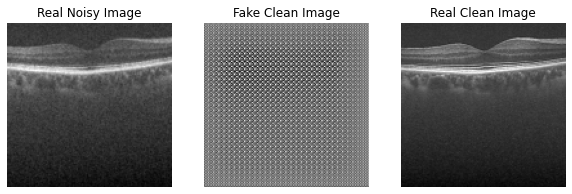

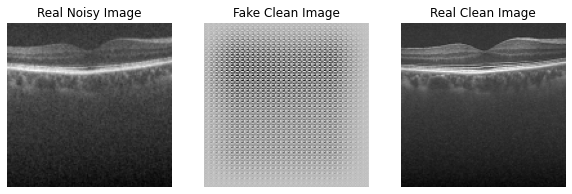

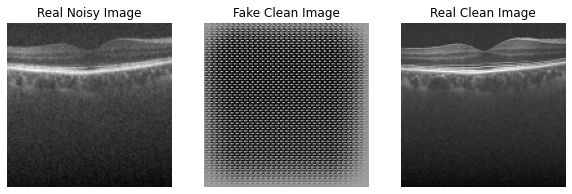

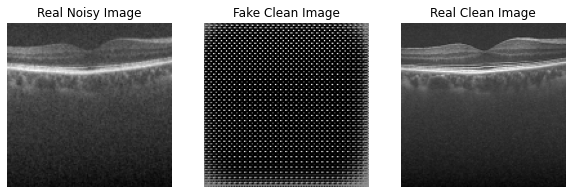

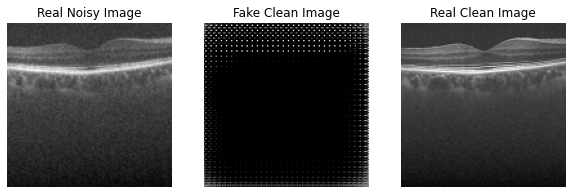

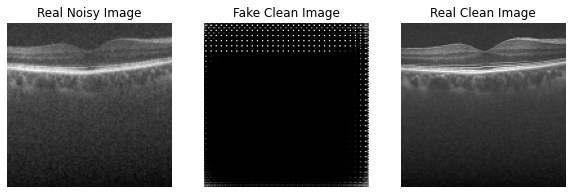

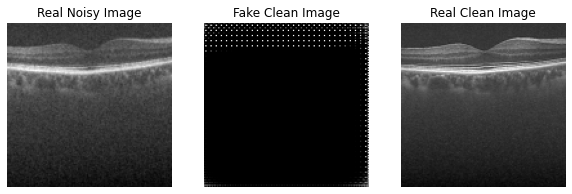

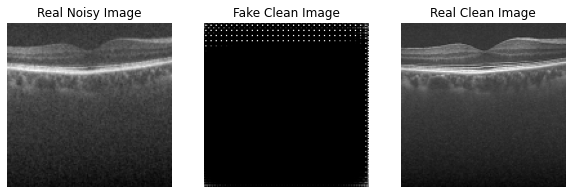

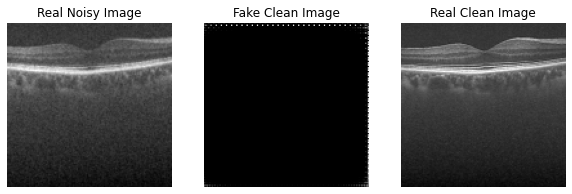

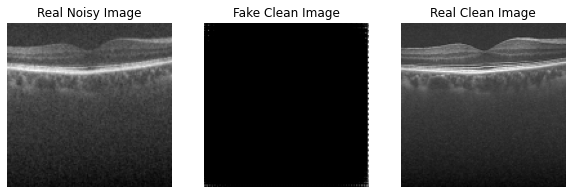

In [146]:
EPOCHS = 10
from timeit import default_timer as timer

start_time = timer()
history = fit(EPOCHS, )
end_time = timer()

print(f"\nTotal Time Taken: {end_time-start_time} seconds")


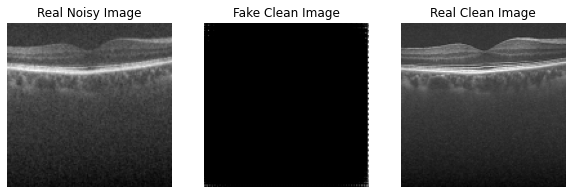

In [147]:
show_sample()